**Business Understanding**

Since from the last notebook, we can infer that there more factors other than time will contribute to the price.
So let's look at our second question: what other information in a listing contributed to the price. This will give us a idea about the reasonable price range of different types of properties and an expectation on your travel expense. For the hosts, this also can guide them to setup the price reasonably. During this process, we will also clean the data, go through each column and decide to drop a few columns. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/calendar_Seattle.csv
/kaggle/input/listings_Boston.csv
/kaggle/input/reviews_Seattle.csv
/kaggle/input/reviews_Boston.csv
/kaggle/input/calendar_Boston.csv
/kaggle/input/listings_Seattle.csv


**Data understanding**

Clearly, this dataset "listings_Seattle.csv" contains all the general information about all the 3818 listings. There are 92 columns. 30 of them are numerical columns. 59 of them are categorical columns. And three of them are datetime columns. Here we will mainly focus on those numerical and short categorical comlumns. That means for those descriptor columns ,like detailed descriptions about the property or the host, we will convert them into a numerical feature contains length of each description. Note that we will also manually drop some columns due to different reasons. And you should be aware of how time-consuming the data cleaning process is. But this process will do us a favor later when we want to build a machine learning model on the dataset.

In [2]:
listing_Sea = pd.read_csv("/kaggle/input/listings_Seattle.csv",parse_dates=['host_since','first_review','last_review'])
listing_Sea.head()
print(listing_Sea.shape)
print(listing_Sea.columns)
print("number of unique listing id is:",listing_Sea['id'].nunique())
print(listing_Sea.dtypes.value_counts())

(3818, 92)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'am

**Data preparation**

We will clean all these features with currency or percentage sign and convert them into float numbers. And there 
are also some categorical variables can be converted into numerical variables by extracting some information. For instance, we can get the number of verifications of the host of each property.And also we can change the feature "host_since" into the feature "host_days", which indicates number of days from the hosting start date to 1/4 2017.Same change was made on "first_review" and "last_review".

In [3]:
## get rid of the dollar sign in the features with currency. 
listing_Sea['price'] = listing_Sea['price'].str.replace('[\$,]', '').astype('float')
listing_Sea['weekly_price'] = listing_Sea['weekly_price'].str.replace('[\$,]', '').astype('float')
listing_Sea['monthly_price'] = listing_Sea['monthly_price'].str.replace('[\$,]', '').astype('float')
listing_Sea['security_deposit'] = listing_Sea['security_deposit'].str.replace('[\$,]', '').astype('float')
listing_Sea['cleaning_fee'] = listing_Sea['cleaning_fee'].str.replace('[\$,]', '').astype('float')
listing_Sea['extra_people'] = listing_Sea['extra_people'].str.replace('[\$,]', '').astype('float')

## get rid of the percentage sign 
listing_Sea['host_response_rate'] = listing_Sea['host_response_rate'].str.replace('[%]', '').astype('float')

## get the number of host verification methods used to verify a host
listing_Sea['number_host_verifications']=listing_Sea['host_verifications'].apply(lambda x:x[1:-1]).str.split(",").apply(lambda x:len(x))

## for those features with dates, get the number of days from that date to 1/4 2017.  
listing_Sea['host_days'] = (np.datetime64('2017-01-04')-listing_Sea['host_since']).dt.days
listing_Sea = listing_Sea.drop(['host_since'],axis=1)
listing_Sea['first_review_days'] = (np.datetime64('2017-01-04')-listing_Sea['first_review']).dt.days
listing_Sea = listing_Sea.drop(['first_review'],axis=1)
listing_Sea['last_review_days'] = (np.datetime64('2017-01-04')-listing_Sea['last_review']).dt.days
listing_Sea = listing_Sea.drop(['last_review'],axis=1)

Firstly, let's take a look at those numerical columns' impact on price.Here we manually drop a few columns, one is "host_total_listings_count" because
it is completely identical to another column "host_listings_count". Another is "license" because it is totally NaN. 
After that we will also drop those columns contain ID information. Since each observation has a unique value in these columns, and it doesn't contain any indication or useful 
information on the price, we need to drop them to decrease the dimensions of our dataset.

In [4]:
numerical_columns = listing_Sea.select_dtypes(include=['int','float'])
print(numerical_columns.columns)

## manually drop the identical columns.
print("Whether 'host_listings_count' and 'host_total_listings_count' are identical?'",listing_Sea['host_listings_count'].equals(listing_Sea['host_total_listings_count']))
listing_Sea = listing_Sea.drop(['host_total_listings_count'],axis=1)
numerical_columns = numerical_columns.drop(['host_total_listings_count'],axis=1)

## manually drop the column that is total NaN.
all_NaN_columns = listing_Sea.columns[listing_Sea.isnull().sum()/listing_Sea.shape[0] == 1.0]
print("Those columns are all NaN:",all_NaN_columns)
listing_Sea= listing_Sea.drop(all_NaN_columns,axis=1)
numerical_columns= numerical_columns.drop(all_NaN_columns,axis=1)

## Drop other columns that will not have influence and indication on price.
listing_Sea = listing_Sea.drop(['id','scrape_id','host_id'],axis=1)
numerical_columns = numerical_columns.drop(['id','scrape_id','host_id'],axis=1)

numerical_columns.head(5)



Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month', 'number_host_verifications', 'host_days',
       'first_review_days', 'last_review_days'],
      dtype='object')
Whether 'host_listings_count' and 'host_total_listings_count' are identical?' True
Those columns are all NaN: Ind

,host_response_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,number_host_verifications,host_days,first_review_days,last_review_days
0,96.0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,NaN,85.0,...,10.0,10.0,9.0,10.0,2,4.07,4,1973.0,1891.0,368.0
1,98.0,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,NaN,150.0,...,10.0,10.0,10.0,10.0,6,1.48,6,1413.0,1234.0,372.0
2,67.0,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,NaN,975.0,...,10.0,10.0,10.0,10.0,2,1.15,5,937.0,889.0,489.0
3,NaN,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,NaN,100.0,...,NaN,NaN,NaN,NaN,1,NaN,5,1155.0,NaN,NaN
4,100.0,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,NaN,450.0,...,10.0,10.0,9.0,9.0,1,0.89,5,1863.0,1639.0,438.0


Here we need to manually drop those columns including the names and those Url information since they are more like the id information.
For other categorical variables, we need to convert those description columns. We will get the length of each description and set it as a numerical feature.
I know by this way, we sort of lose some information. But at least we retain some information,and we also have an indicator saying whether this description is null or not.
We also need to delete those columns with only one unique value since they will not help at all in our model later.

In [5]:
## get all the current categorical features
Categorical_columns = listing_Sea.select_dtypes(include=['object']).columns
print(Categorical_columns)

## drop all the features about the property name, host name, url.
drop_cat_columns=['listing_url','name','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name','host_thumbnail_url','host_picture_url']

## list all the features with descriptions.
descriptor = ['summary','space','description','neighborhood_overview','notes','transit','host_about']

## for all the description features, get the length of the description and save it to another feature.Then drop the original 
## description deature.
listing_Sea = listing_Sea.drop(drop_cat_columns,axis=1)
for col in descriptor:
    #print(col)
    listing_Sea[col+"_len"] = listing_Sea[col].apply(lambda x: len(str(x).split(" ")) if not x == False else 0)
    listing_Sea=listing_Sea.drop(col,axis=1)

## Drop the categorical features with only one single unique value.
Categorical_columns = listing_Sea.select_dtypes(include=['object'])
single_val_col = Categorical_columns.columns[(Categorical_columns.nunique()==1)]
Categorical_columns = Categorical_columns.drop(single_val_col,axis=1)
listing_Sea = listing_Sea.drop(single_val_col,axis=1)


Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_location',
       'host_about', 'host_response_time', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 're

Also we need to manually delete the column "host_verifications","state","city", and "smart_location". The reason is: for "host_verifications", we already extract the information from it in the code above. For "state", it actually only has one category just because of capital case letters and lower case letters. The column "city" and "smart_location" actually do not provide many categories. Most of categories are actually the same and are seen as different categories because of languages and format. Further, this geographical information has been included in some other columns like "neighbourhood" and "zipcode".

In [6]:
Categorical_columns = Categorical_columns.drop(['host_verifications','state','city','smart_location'],axis=1)
listing_Sea = listing_Sea.drop(['host_verifications','state','city','smart_location'],axis=1)
Categorical_columns.head()

,host_location,host_response_time,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,is_location_exact,property_type,room_type,bed_type,amenities,calendar_updated,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,"Seattle, Washington, United States",within a few hours,100%,f,Queen Anne,t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4 weeks ago,f,moderate,f,f
1,"Seattle, Washington, United States",within an hour,100%,t,Queen Anne,t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,t,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",today,f,strict,t,t
2,"Seattle, Washington, United States",within a few hours,100%,f,Queen Anne,t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,t,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5 weeks ago,f,strict,f,f
3,"Seattle, Washington, United States",NaN,NaN,f,Queen Anne,t,t,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,t,Apartment,Entire home/apt,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",6 months ago,f,flexible,f,f
4,"Seattle, Washington, United States",within an hour,NaN,f,Queen Anne,t,t,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,t,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",7 weeks ago,f,strict,f,f


**Data interpretation**

Now we begin to answer our second question, what are those other factors that have significant impact on AirBnB listing prices. To do this, we firstly need to plot the distribution of price in Seattle. And then we will do couple plots and visualizations to give a deeper insight. You may find the price exhibits a right skewed shape. This suggests some properties have significantly higher prices than the majority. But most properties'prices are in a narrow range.

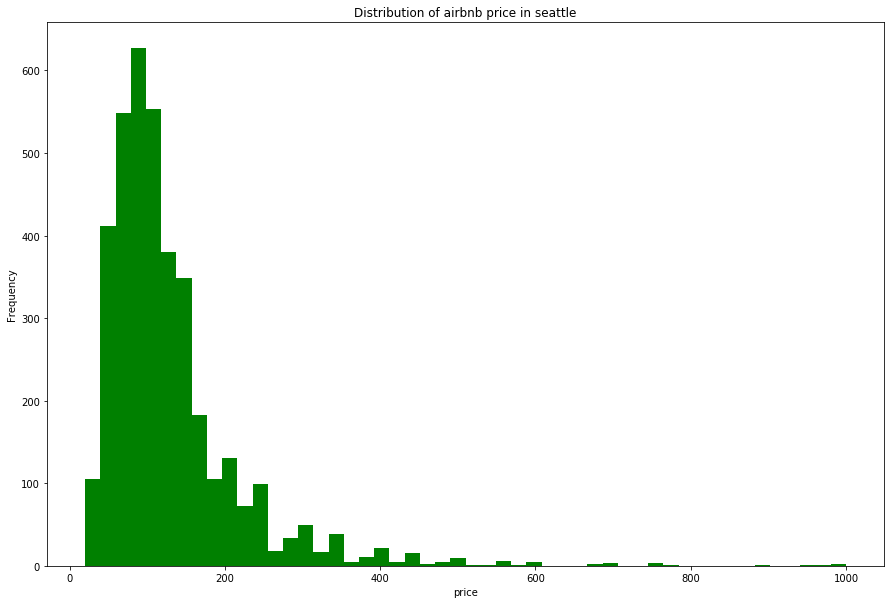

In [7]:
## Plot the distribution of price
plt.figure(figsize=(15,10))
plt.hist(listing_Sea['price'],bins=50,facecolor='g')
plt.xlabel("price")
plt.ylabel("Frequency")
plt.title("Distribution of airbnb price in seattle")
plt.show()

The figure below exhibits the correlation between price and all other numerical variables. Not surprisingly, all the variables indicating 
the scale of the property , like guests included, square feet of the property,and number of bedrooms,has very positive correlation with price. Weekyly price and monthly price are definitely proportional to the unit price, so we may need to exclude them in our models later. 

We also ploted some scatter plots and box plots to more directly illustrate the correlation between price and some of those numerical variables. One thing to note is there so many different variables so we cannot analysis each of them one by one in details. I will just choose some of them that are representative.

A few interesting points:
* Minimum and maximum nights have very small correlations with price.
* Number of reviews looks like have negative impact on the price. More reviews indicate lower prices.
* Generally, higher review scores on all the aspects indicate a higher price. But there is one exception, which is "reviews_scores_value".
* longitude has negative correlation with price, that may reflect the coumunity and environment's impact.
* Availability generally has negative effect on price.
* Length of descriptions usually has an negative correlation with price.

Index(['host_response_rate', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'number_host_verifications', 'host_days', 'first_review_days',
       'last_review_days', 'summary_len', 'space_len', 'description_len',
       'neighborhood_overview_len', 'notes_len', 'transit_len',
       'host_about_len'],
      dtype='object')


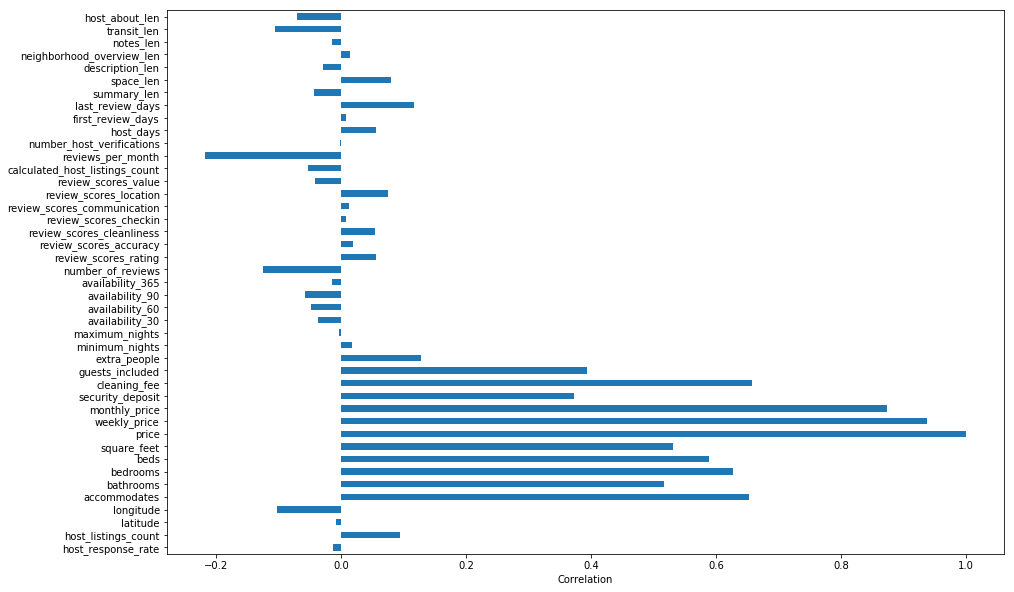

In [8]:
## plot the correlation between price and each numerical feature
numerical_columns = listing_Sea.select_dtypes(include=['int','float'])
print(numerical_columns.columns)
plt.figure(figsize=(15,10))
Corr_price = numerical_columns.corr()['price'][:]

Corr_price.plot.barh()
plt.xlabel("Correlation")
plt.show()

Clearly, from the boxplots below, a larger property has a higher price. You may find there is an increasing trend of price with the increase of bedroom number, bathroom number, and accommodate number. Some of them have very large error bar so they have overlapped with neighboring groups. For those luxury properties, the data is not very reliable due to a lack of sampling. 

Text(0, 0.5, 'Price')

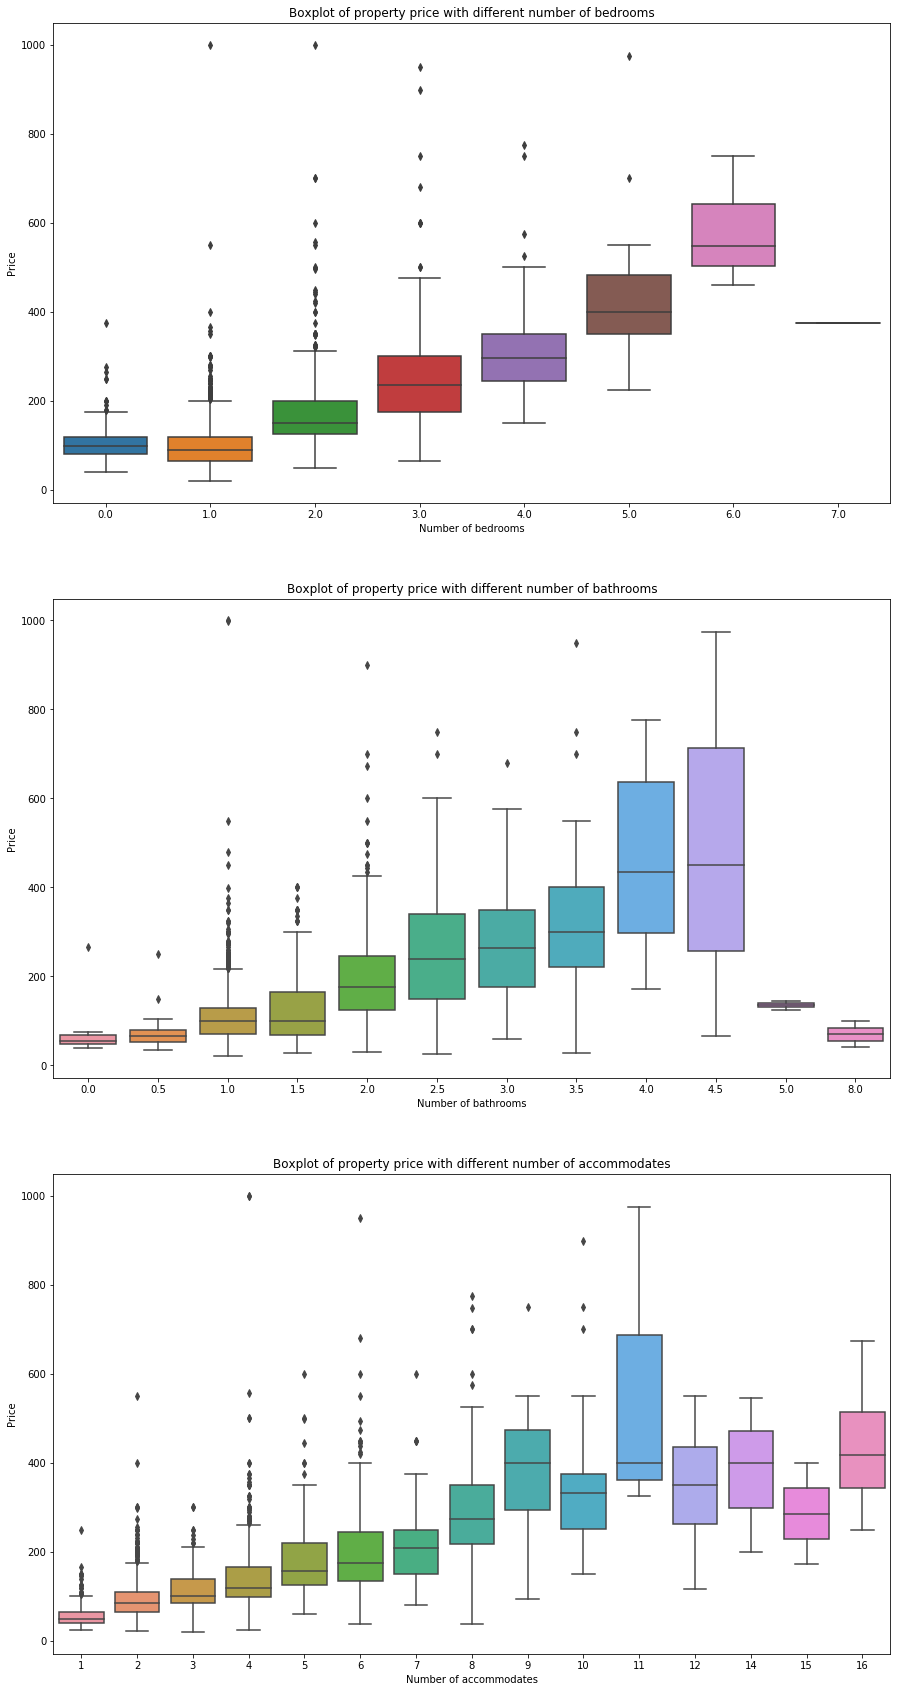

In [9]:
## More plots about the correlation between price and numerical variables.

plt.figure(figsize=(15,30))
plt.subplot(3,1,1)
sns.boxplot(x='bedrooms',y='price',data=listing_Sea)
plt.title("Boxplot of property price with different number of bedrooms")
plt.xlabel('Number of bedrooms')
plt.ylabel('Price')

plt.subplot(3,1,2)
sns.boxplot(x='bathrooms',y='price',data=listing_Sea)
plt.title("Boxplot of property price with different number of bathrooms")
plt.xlabel('Number of bathrooms')
plt.ylabel('Price')

plt.subplot(3,1,3)
sns.boxplot(x='accommodates',y='price',data=listing_Sea)
plt.title("Boxplot of property price with different number of accommodates")
plt.xlabel('Number of accommodates')
plt.ylabel('Price')

#plt.show()

The correlation between price and numerical variables can be visualized by scatter plots. In each distinct continuous value, we can even add the standard deviation of prices with this value. But you may also find the figure become less elegant after this. But you may still find the increasing price trend with the increasing of those extra fees like security deposit and cleaning fee. The number of reviews doesn't exhibit a significant influence on price, but you can see almost all the properties with large number of reviews are in the relative lower price region.

Text(0.5, 1.0, 'Price vs Reviews per month')

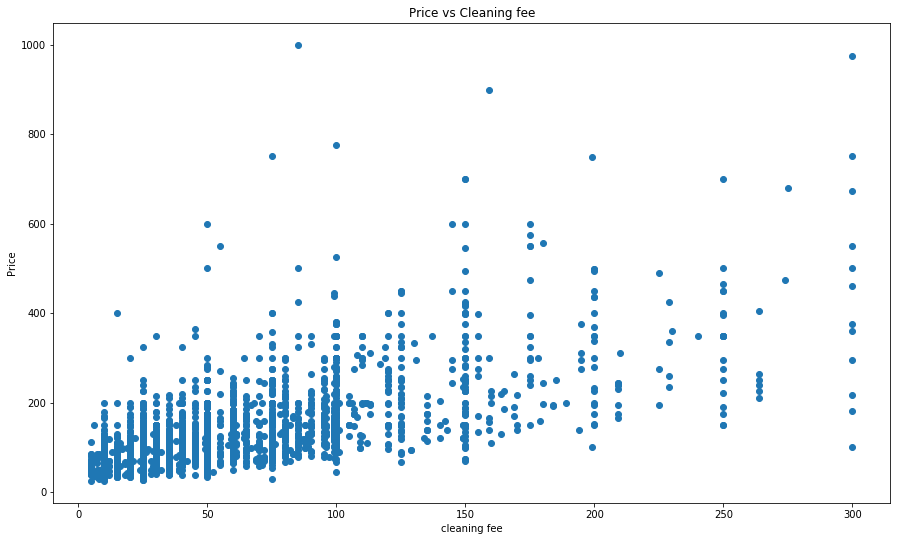

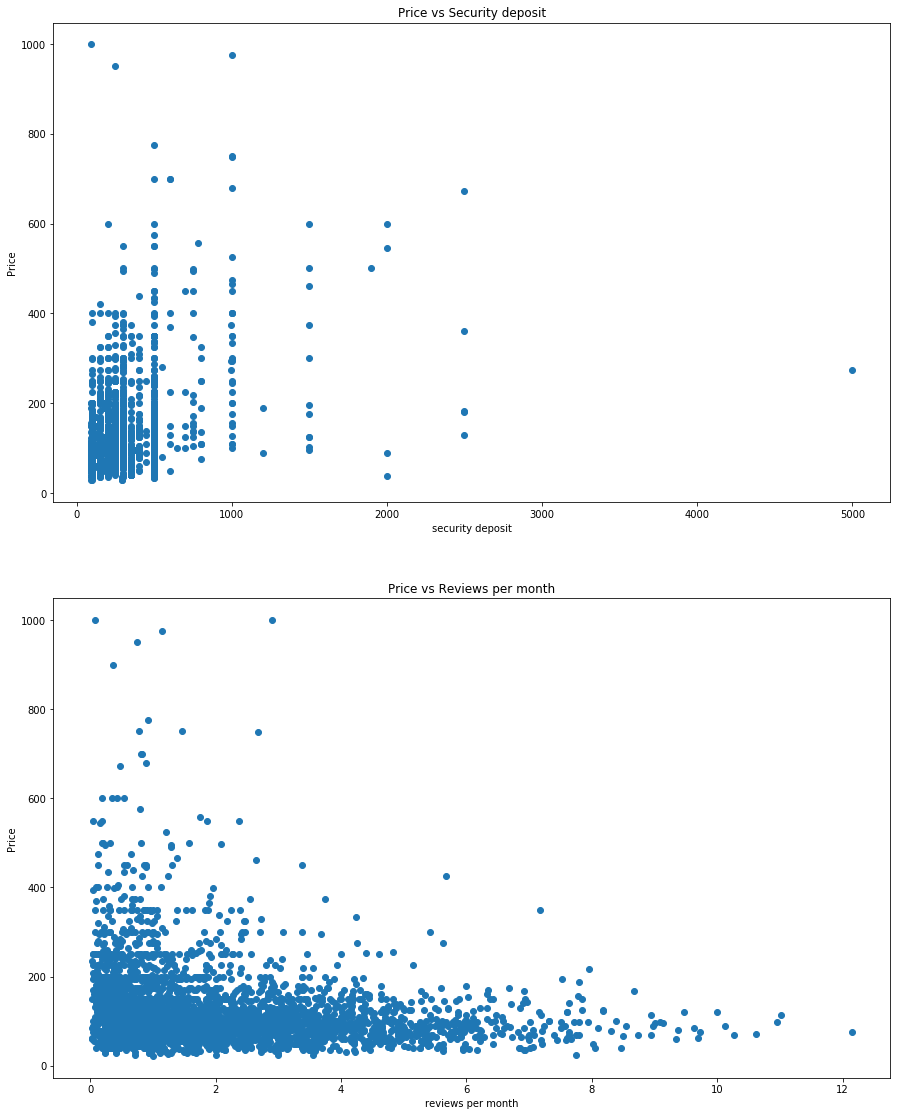

In [10]:
## More plots about the correlation between price and numerical variables.

plt.figure(figsize=(15,30))
plt.subplot(3,1,1)
plt.scatter(listing_Sea['cleaning_fee'],listing_Sea['price'])
plt.xlabel('cleaning fee')
plt.ylabel('Price')
plt.title('Price vs Cleaning fee')
plt.figure(figsize=(15,30))
plt.subplot(3,1,2)
plt.scatter(listing_Sea['security_deposit'],listing_Sea['price'])
plt.xlabel('security deposit')
plt.ylabel('Price')
plt.title('Price vs Security deposit')
plt.subplot(3,1,3)
plt.scatter(listing_Sea['reviews_per_month'],listing_Sea['price'])
plt.xlabel('reviews per month')
plt.ylabel('Price')
plt.title('Price vs Reviews per month')

Text(0.5, 1.0, 'Price vs Cleaning fee')

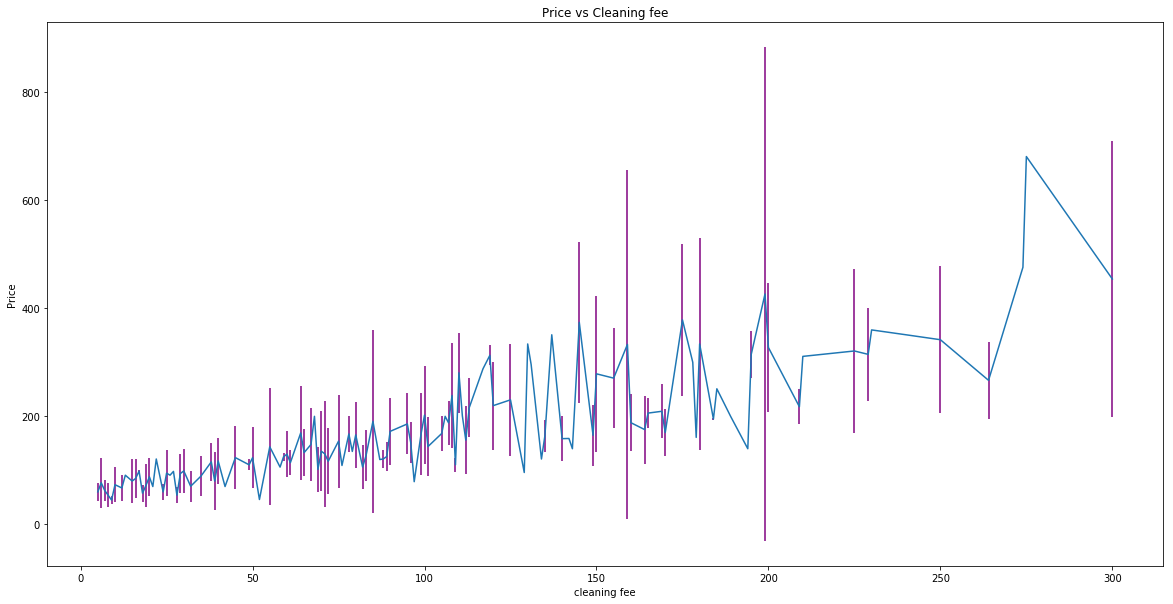

In [11]:
## Group the data by some certain continuous variables and calculate the average and standard deviation of price
## in each group.

def Group_by_price(variable):
    '''
    INPUT:
    variable - the variable needed to group the data by and caculate the average price
    
    OUTPUT:
    stat - average price in each category in the input variable
    '''
    stat = listing_Sea.groupby(variable).agg({'price':['mean','std']})
    stat = stat.reset_index()
    stat.columns=['label','avg_price','stdev']
    return stat

## Test function Group_by_price
## Plot the average price as a function of cleaning fee
plt.figure(figsize=(20,10))
stat_cleaning_fee=Group_by_price('cleaning_fee')
plt.errorbar(stat_cleaning_fee['label'],stat_cleaning_fee['avg_price'],yerr=stat_cleaning_fee['stdev'],ecolor='purple')
plt.xlabel('cleaning fee')
plt.ylabel('Price')
plt.title('Price vs Cleaning fee')

Text(0.5, 1.0, 'Price vs Security deposit')

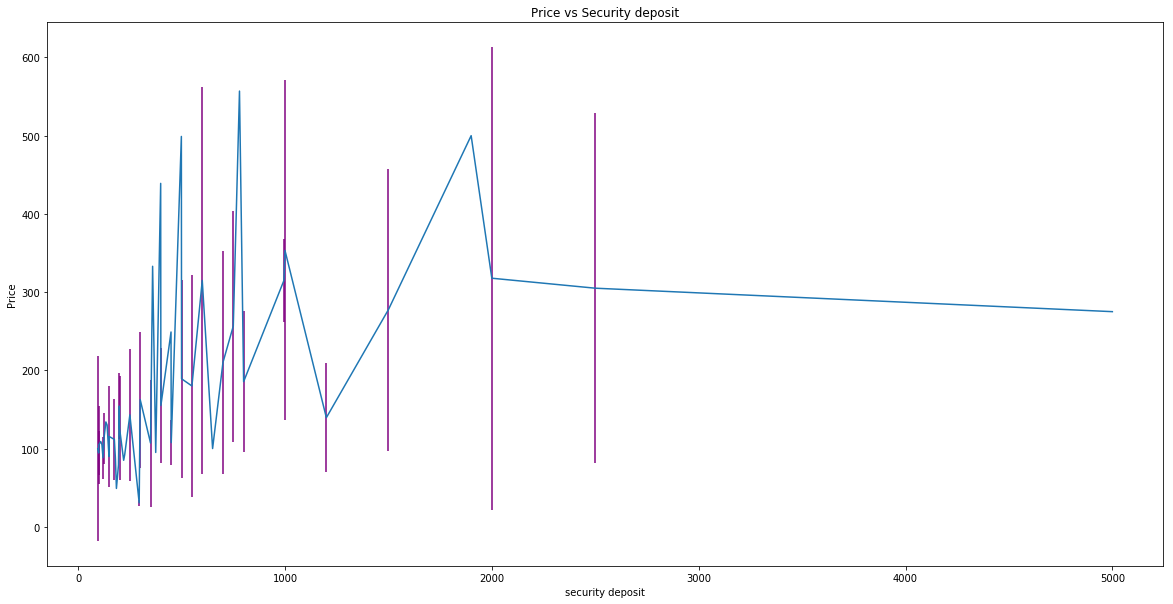

In [12]:
## Plot the average price as a function of security deposit
plt.figure(figsize=(20,10))
stat_security_deposit=Group_by_price('security_deposit')
plt.errorbar(stat_security_deposit['label'],stat_security_deposit['avg_price'],yerr=stat_security_deposit['stdev'],ecolor='purple')
plt.xlabel('security deposit')
plt.ylabel('Price')
plt.title('Price vs Security deposit')

Text(0.5, 1.0, 'Price vs Reviews per month')

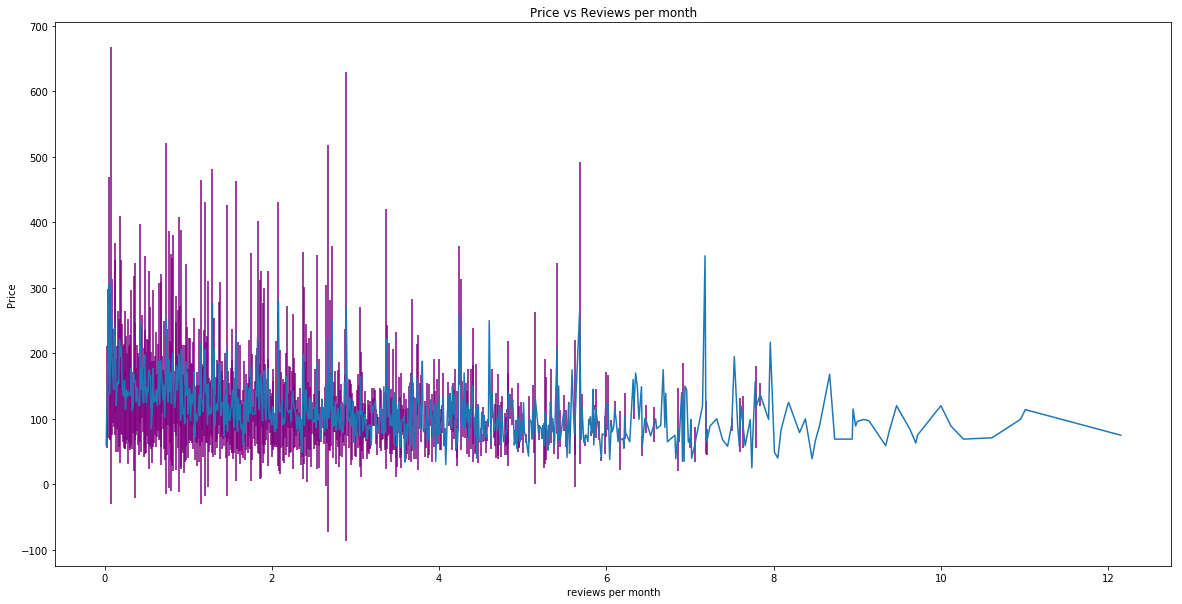

In [13]:
## Plot the average price as a function of reviews per month
plt.figure(figsize=(20,10))
stat_reviews_per_month=Group_by_price('reviews_per_month')
plt.errorbar(stat_reviews_per_month['label'],stat_reviews_per_month['avg_price'],yerr=stat_reviews_per_month['stdev'],ecolor='purple')
plt.xlabel('reviews per month')
plt.ylabel('Price')
plt.title('Price vs Reviews per month')

Finally, we can visualize the impact of some categorical variables on the price. There are 16 different property types. The most expensive one is boat. Dorm and tent have the lowest prices. These two sounds like temporary housing during a visit. For the bed types, real bed has the highest price, and I am sure it is the most popular one. All the other types, no matter Couch or air-bed may not provide as comfortable experience as a real bed did. In the room type part, an entire home has the highest price. And correspondingly, a shared room is the cheapest.Host response time doesn't have significant impact, hosts response within one hour usually has lower prices. For the cancellation policy, those properties with strict cancellation policy have much higher price than others.

Text(0.5, 1.0, 'Avg price of different cancellation policy')

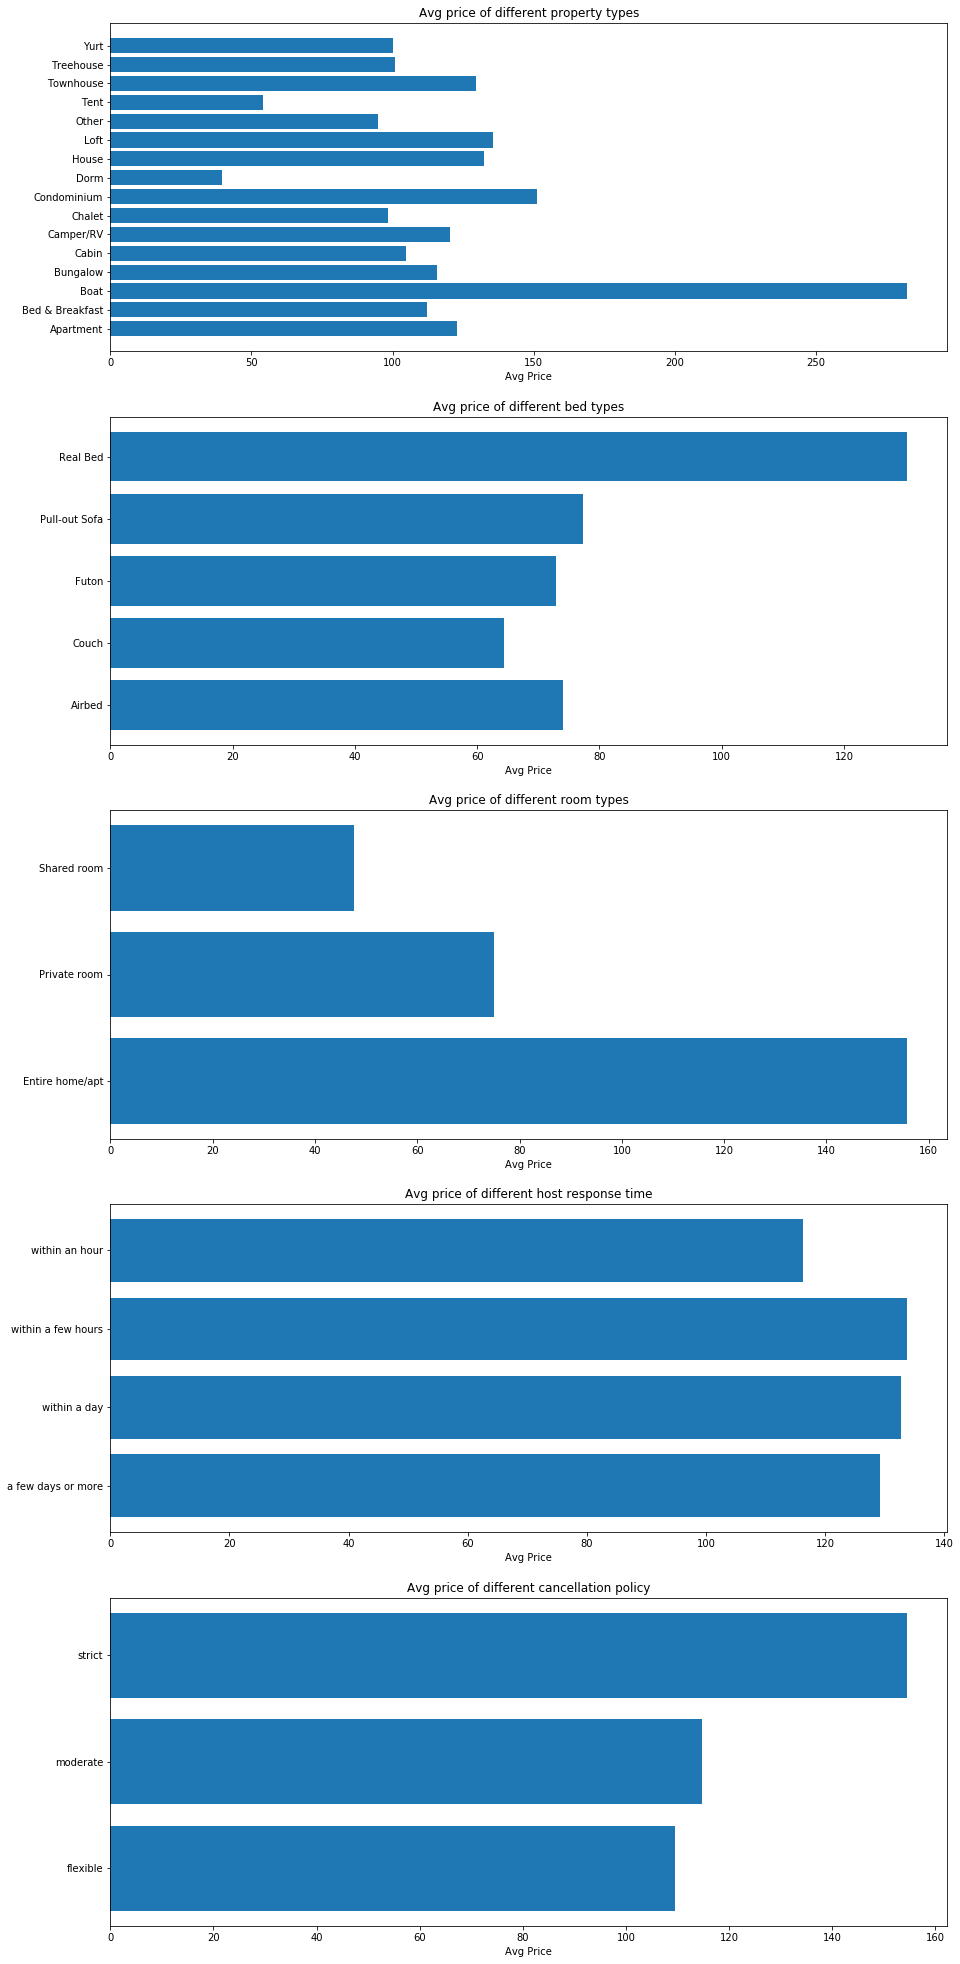

In [14]:
## Plot the average price in different property types
plt.figure(figsize=(15,35))
plt.subplot(5,1,1)
stat_property_type=Group_by_price('property_type')
plt.barh(stat_property_type['label'],stat_property_type['avg_price'],)
plt.xlabel("Avg Price")
plt.title("Avg price of different property types")


## Plot the average price in different bed types
plt.subplot(5,1,2)
stat_bed_type =Group_by_price('bed_type')
plt.barh(stat_bed_type ['label'],stat_bed_type ['avg_price'],)
plt.xlabel("Avg Price")
plt.title("Avg price of different bed types")


## Plot the average price in different room types
plt.subplot(5,1,3)
stat_host_response_time =Group_by_price('room_type')
plt.barh(stat_host_response_time['label'],stat_host_response_time['avg_price'],)
plt.xlabel("Avg Price")
plt.title("Avg price of different room types")


## Plot the average price in different host response time
plt.subplot(5,1,4)
stat_host_response_time =Group_by_price('host_response_time')
plt.barh(stat_host_response_time['label'],stat_host_response_time['avg_price'],)
plt.xlabel("Avg Price")
plt.title("Avg price of different host response time")



## Plot the average price in different cancellation policy
plt.subplot(5,1,5)
stat_host_response_time =Group_by_price('cancellation_policy')
plt.barh(stat_host_response_time['label'],stat_host_response_time['avg_price'],)
plt.xlabel("Avg Price")
plt.title("Avg price of different cancellation policy")



**Conclusion**

We investigated many different variables that contribute to different prices. Some of them are very natural, like those directly related to the price and size of the property. But some of them are quite surprising, like the number of reviews. Then it come to our final question, how can we predict the price based on the data we have. 
To address this final question, we need to save our cleaned data to a file for use in the model later.

In [15]:
## Check the final shape of cleaned dataset, and save it to csv file.
print(listing_Sea.shape)
listing_Sea.to_csv("Listing_cleaned.csv")

(3818, 65)


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 